In [1]:
! pip -q install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [3]:
! git clone https://github.com/LM1997610/Apex_detection

Cloning into 'Apex_detection'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (13/13), 15.39 KiB | 15.39 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [4]:
import tensorflow as tf
import warnings

from datasets import load_dataset

import torch
import torchvision
from torchvision.transforms import v2 as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from apex_dataload import ApexDetection

import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [5]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")

  dataset = load_dataset(path='Francesco/apex-videogame')

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [6]:
for key in dataset:

    dataset[key] = dataset[key].flatten()
    dataset[key] = dataset[key].filter(lambda example: tf.shape(example['objects.bbox'])[0] > 0)

train_d = dataset['train']
val_d = dataset['validation']
test_d = dataset['test']

Filter:   0%|          | 0/2583 [00:00<?, ? examples/s]

Filter:   0%|          | 0/415 [00:00<?, ? examples/s]

Filter:   0%|          | 0/691 [00:00<?, ? examples/s]

In [246]:
def collate_fn(batch):
    return tuple(zip(*batch))

def get_transform(train=False):
    transforms = []

    if train:
        transforms.extend([T.RandomHorizontalFlip(0.5),
                           T.RandomRotation(degrees=35),
                           T.RandomResizedCrop(size=(640, 640)),
                           T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                           T.GaussianBlur(kernel_size=3)])

    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())

    return T.Compose(transforms)

In [247]:
train_data = ApexDetection(root = train_d, transforms = get_transform(train=True))
val_data = ApexDetection(root = val_d, transforms = get_transform(train=True))
test_data = ApexDetection(root = test_d)

data_loader_train = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
data_loader_val = torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=False, collate_fn=collate_fn)

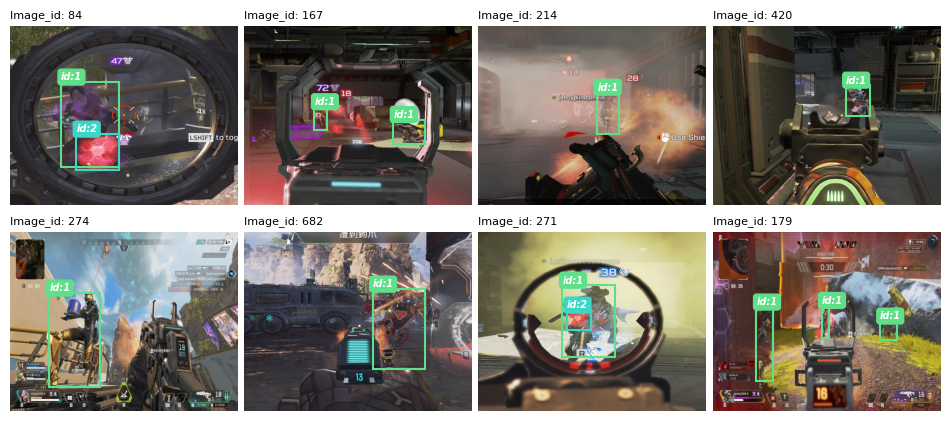

In [248]:
f, axs = plt.subplots(2, 4, sharey=True, figsize=(12, 5))
axs = axs.flatten()

imgs_index = [0, 3, 6, 8, 10, 14, 47, 572]

for i, ax in zip(imgs_index, axs):

    test_data.do_plot(i, ax=ax)

plt.subplots_adjust(wspace=0.03, hspace=0.15)
plt.show()

In [10]:
num_classes = 3
batch_size = 16

num_epochs = 8

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")

  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.roi_heads.detections_per_img = 10

model=model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 129MB/s]


In [12]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [13]:
from engine import train_one_epoch, evaluate

In [ ]:
history_train = []
history_val = []

for epoch in range(num_epochs):

    h = train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=100)
    lr_scheduler.step()
    history_train.append(h.meters)

    #if epoch % 2 == 0:
    #   v = evaluate(model, data_loader_val, device=device)
    #   history_val.append(v)

# model = torch.load('model.pth')

In [ ]:
# ! gdown 1B_e2BfbgnYFUv5Tb2_li32WnSDKSoHpY

In [91]:
# model.load_state_dict(torch.load("the_model_v1.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

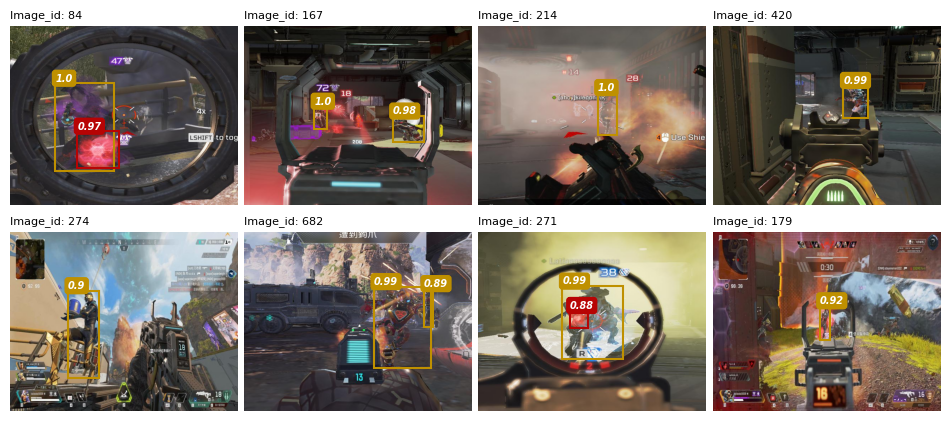

In [253]:
f, axs = plt.subplots(2, 4, sharey=True, figsize=(12, 5))
axs = axs.flatten()

imgs_index = [0, 3, 6, 8, 10, 14, 47, 572]

for i, ax in zip(imgs_index, axs):

    test_data.do_plot(i, ax=ax, model=model, treshold=0.87)

plt.subplots_adjust(wspace=0.03, hspace=0.15)
plt.show()

In [270]:
img, target = test_data.__getitem__(idx=3)

start_time = time.time()
boxes, labels, scores = test_data.__prediction__(img, model, threshold=0.97)

elapsed_time = time.time() - start_time

print("Time taken:", elapsed_time, "seconds")

Time taken: 5.148483991622925 seconds


In [245]:

import torch
from torchvision import datasets
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import torchvision

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

class ApexDetection(datasets.VisionDataset):

    def __init__(self, root: str, split = "train", transforms= None) -> None:

        super().__init__(root, transforms)
        self.split = split
        self.root = root
        self.ids = [i for i in range(len(self.root))]
        self.transforms = transforms

    def _load_image(self, idx: int):
      image = self.root[idx]['image']
      image = tv_tensors.Image(image)
      image = image.float() / 255.0
      return image

    def _load_target(self, idx: int):
      target = self.root[idx]['objects.category']
      target = torch.tensor(target, dtype=torch.int64)
      return target

    def _load_box(self, idx: int, img):
      bbox = self.root[idx]['objects.bbox']
      bbox = tv_tensors.BoundingBoxes(bbox, format="XYWH", canvas_size=F.get_size(img))
      bbox = torchvision.ops.box_convert(bbox, in_fmt="xywh", out_fmt="xyxy")
      return bbox

    def __getitem__(self, idx:int):
      image = self._load_image(idx)
      bbox = self._load_box(idx, image)
      label = self._load_target(idx)

      target = {}
      target["boxes"] = bbox
      target["labels"] = label
      target["image_id"] = torch.tensor(self.root[idx]['image_id'], dtype=torch.int64)
      target["area"] = torch.tensor(self.root[idx]['objects.area'], dtype=torch.int64)
      target["iscrowd"]= torch.zeros((len(label),), dtype=torch.int64)

      if self.transforms is not None:
            image, target = self.transforms(image, target)

      return image, target

    def __len__(self):
        return len(self.ids)

    def __prediction__(self, img, model, threshold):
       img = img.permute(0,1,2).unsqueeze(0)
       model.eval()
       prediction = model(img)

       top_predictions = self.__filter_prediction__(prediction[0], threshold)

       boxes = top_predictions['boxes'].cpu().detach().numpy()
       labels = top_predictions['labels'].cpu().detach().numpy()
       scores = top_predictions['scores'].cpu().detach().numpy()

       return boxes, labels, scores

    def __filter_prediction__(self, a_dict: dict, threshold):

       filtered_dict = {key: [value[idx] for idx, score in enumerate(a_dict['scores']) if score > threshold]
                              for key, value in a_dict.items()}

       if not all(not v for v in filtered_dict.values()):
        filtered_dict = {key: torch.stack(value) if isinstance(value, list) else value
                          for key, value in filtered_dict.items()}
       else:
          filtered_dict = {'boxes': torch.tensor([np.zeros(4)]),
                             'labels': torch.tensor(np.zeros(1)), 'scores': torch.tensor(np.zeros(1))}
       return filtered_dict

    def do_plot(self, idx:int, ax=None, model=None, treshold = 0.95):

      image, target = self. __getitem__(idx)
      boxes, labels, image_id = target['boxes'], target['labels'], target['image_id']
      scores = [1 for _ in range(len(boxes))]

      if ax is None:
        ax = plt.gca()

      ax.set_axis_off()
      ax.set_title("Image_id: "+str(image_id.detach().numpy()), fontsize=8, loc='left')
      bp = ax.imshow(image.squeeze(0).permute(1, 2, 0), aspect="auto")

      if model:
        boxes, labels, scores = self.__prediction__(image, model, treshold)

      colors = ['#BF9000', '#B70404'] if model else ['#60DF89','#3BD6C6']

      for box, label, s  in zip(boxes, labels, scores):
        x,y,w,h = box

        color = colors[0] if label==1 else colors[1]

        rect = patches.Rectangle((x, y), w-x, h-y, linewidth=1.5, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        text = np.round(s, 2) if model else 'id:'+str(label.detach().numpy())
        ax.text(x, y, f'{str(text)}', ha='left', va='bottom', color="white", fontsize=7, fontstyle='italic', fontweight="bold",
                bbox=dict(facecolor=color if s >0 else 'none', edgecolor=color if s >0 else 'none', boxstyle='round'))

      return bp
